<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Projects/blob/main/Intermediate/PyTorch-TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog vs. Cat Classifier with Transfer Learning

In [12]:
!pip install torchmetrics torchviz

# Download Dataset

In [2]:
# --- Configuration and Setup ---
import os

# Ensure Kaggle is configured for dataset download
# Upload kaggle.json to colab's /content/ directory
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
os.system('cp /content/kaggle.json ~/.kaggle/')
os.system('chmod 600 ~/.kaggle/kaggle.json')

# Download and extract the dogs vs cats dataset
# This part assumes the dataset isn't already extracted.
# If it is, then comment out or skip these lines.
os.system('kaggle datasets download -d salader/dogs-vs-cats')
os.system('unzip -q dogs-vs-cats.zip -d dogs_vs_cats_data')

0

# Import Libraries

In [26]:
import torch
import torch.nn as nn
import torchvision as tv
import torchmetrics as tm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image as DisplayImage

# Custom Dataset Class

In [4]:
class DogsCatsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Iterate through class subdirectories within the root_dir
        for class_name in ['dogs', 'cats']:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for image_file in os.listdir(class_path):
                    self.image_files.append(os.path.join(class_path, image_file))
                    # Assign labels: 0 for 'cats', 1 for 'dogs'
                    self.labels.append(0 if class_name == 'cats' else 1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load Dataset

Label: Dog


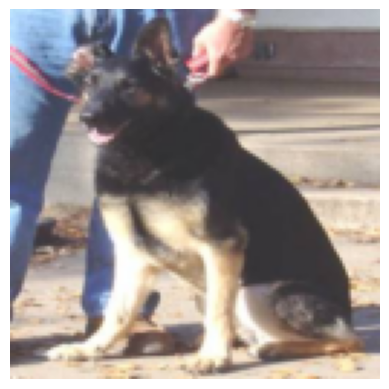

In [16]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load Dataset
train_dataset = DogsCatsDataset("/content/dogs_vs_cats_data/train", transform = transform)
test_dataset = DogsCatsDataset("/content/dogs_vs_cats_data/test", transform = transform)

# Display Image
img, label = train_dataset[0]
print(f"Label: {'Cat' if label == 0 else 'Dog'}")
plt.imshow(np.transpose(img.numpy(), (1,2,0)))
plt.axis("off")
plt.show()

In [17]:
# Define DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True,
    num_workers = 2,
    persistent_workers = False,
    pin_memory = True,
    prefetch_factor = 2
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = False,
    num_workers = 2,
    persistent_workers = False,
    pin_memory = True,
    prefetch_factor = 2
)

# CNN Model (Baseline)

In [22]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.mp1 = nn.MaxPool2d(kernel_size=2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.mp2 = nn.MaxPool2d(kernel_size=2)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.relu3 = nn.ReLU()
    self.mp3 = nn.MaxPool2d(kernel_size=2)

    self.drop = nn.Dropout(0.3)
    self.flat = nn.Flatten()
    self.out = nn.Linear(128 * 16 * 16, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.mp1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.mp2(x)

    x = self.conv3(x)
    x = self.relu3(x)
    x = self.mp3(x)

    x = self.drop(x)
    x = self.flat(x)
    x = self.out(x)

    return x

In [23]:
# Set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Initialize Model
baseline_cnn = CNN().to(device)

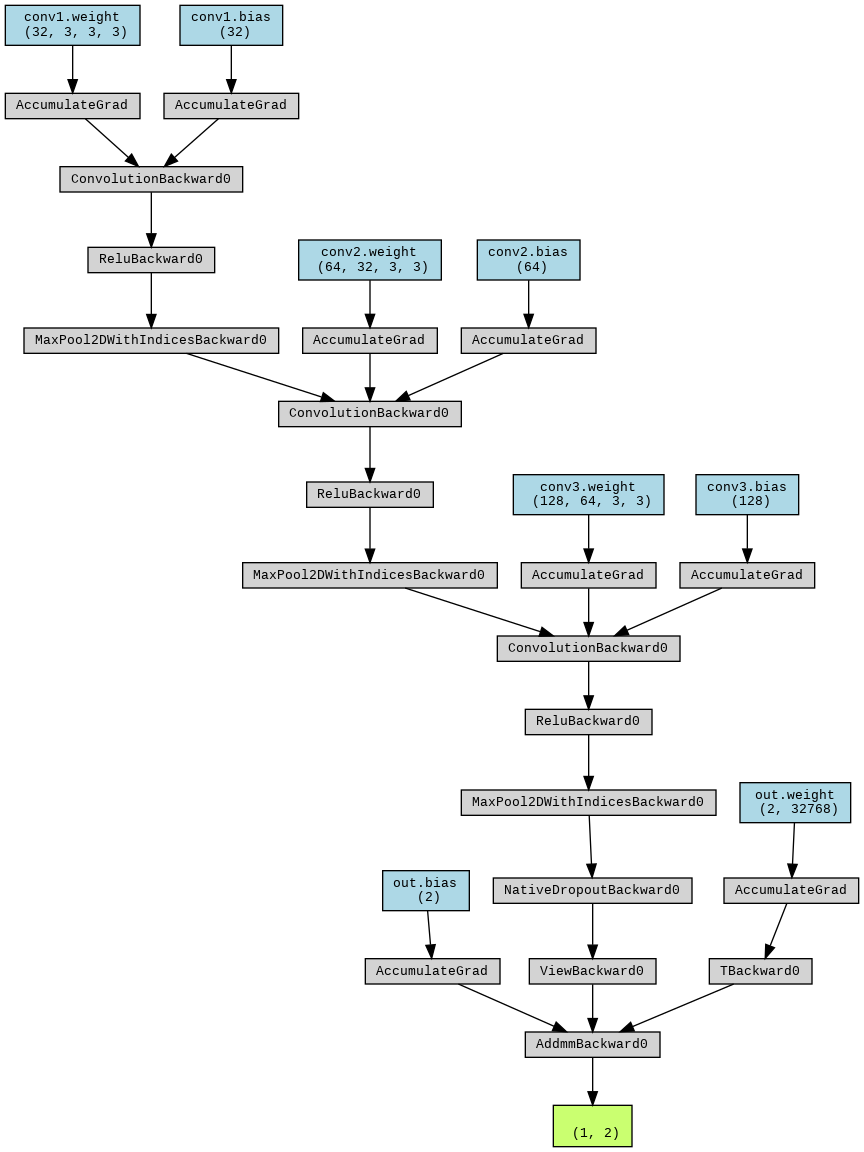

In [29]:
# Visualize Model Architecture

# Generate Dummy Input
dum_inp = torch.randn(1, 3, 128, 128).to(device)
output_graph = baseline_cnn(dum_inp)

# Visualize The Commputational Graph
dot = make_dot(
    output_graph,
    params = dict(list(baseline_cnn.named_parameters()))
)

dot.render("baseline_cnn_graph", format = "png", cleanup = True)

DisplayImage(filename = "baseline_cnn_graph.png")

In [28]:
# Define Loss Function and Optimizer
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_cnn.parameters(), lr = lr)

In [31]:
# Training Loop
train_loss = []
EPOCHS = 25

for epoch in range(1, EPOCHS+1):
  baseline_cnn.train()
  epoch_loss = 0.0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = baseline_cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  epoch_loss = epoch_loss / len(train_loader)
  train_loss.append(epoch_loss)

  print(f"Epoch: {epoch}/{EPOCHS} | Training Loss: {epoch_loss}")

Epoch: 1/25 | Training Loss: 0.5870683762550354
Epoch: 2/25 | Training Loss: 0.5021588777065277
Epoch: 3/25 | Training Loss: 0.44206977112293244
Epoch: 4/25 | Training Loss: 0.40090230567455293
Epoch: 5/25 | Training Loss: 0.3622255631685257
Epoch: 6/25 | Training Loss: 0.329901617872715
Epoch: 7/25 | Training Loss: 0.2919860040307045
Epoch: 8/25 | Training Loss: 0.2653195945739746
Epoch: 9/25 | Training Loss: 0.24330774765014648
Epoch: 10/25 | Training Loss: 0.21937295357882977
Epoch: 11/25 | Training Loss: 0.19493626695275307
Epoch: 12/25 | Training Loss: 0.18100240918546914
Epoch: 13/25 | Training Loss: 0.16385639835894109
Epoch: 14/25 | Training Loss: 0.15187809512913228
Epoch: 15/25 | Training Loss: 0.14113213378936051
Epoch: 16/25 | Training Loss: 0.1278027809381485
Epoch: 17/25 | Training Loss: 0.12275052723288536
Epoch: 18/25 | Training Loss: 0.12020908710807562
Epoch: 19/25 | Training Loss: 0.10650300053954125
Epoch: 20/25 | Training Loss: 0.09811967439800501
Epoch: 21/25 | Tr

/tmp/ipython-input-408104775.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


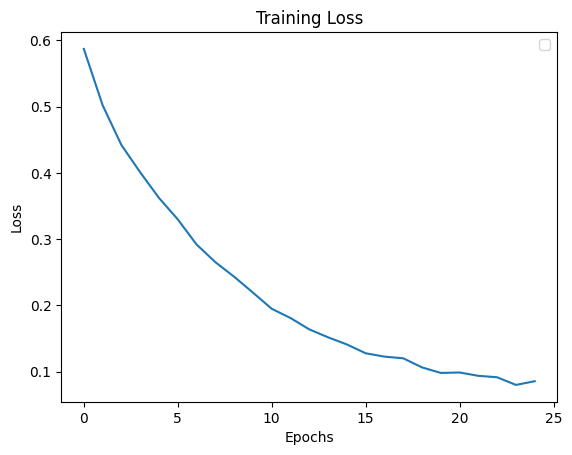

In [32]:
# Plot Learning Curves
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
# Define Evaluation Metrics
accuracy = tm.Accuracy(
    task = "binary",
    num_classes = 2,
    average = "macro"
).to(device)

precision = tm.Precision(
    task = "binary",
    num_classes = 2,
    average = "macro"
).to(device)

recall = tm.Recall(
    task = "binary",
    num_classes = 2,
    average = "macro"
).to(device)

# Initialize Confusion Matrix
confusion_matrix = tm.ConfusionMatrix(
    task = "Binary",
    num_classes = 10
).to(device)

In [35]:
# Evaluate Model
baseline_cnn.eval()

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = baseline_cnn(images)
    preds = torch.argmax(outputs, dim=1)

    accuracy(preds, labels)
    precision(preds, labels)
    recall(preds, labels)
    confusion_matrix(preds, labels)

acc = accuracy.compute()
prec = precision.compute()
rec = recall.compute()

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')

Accuracy: 0.8630
Precision: 0.8954
Recall: 0.8220


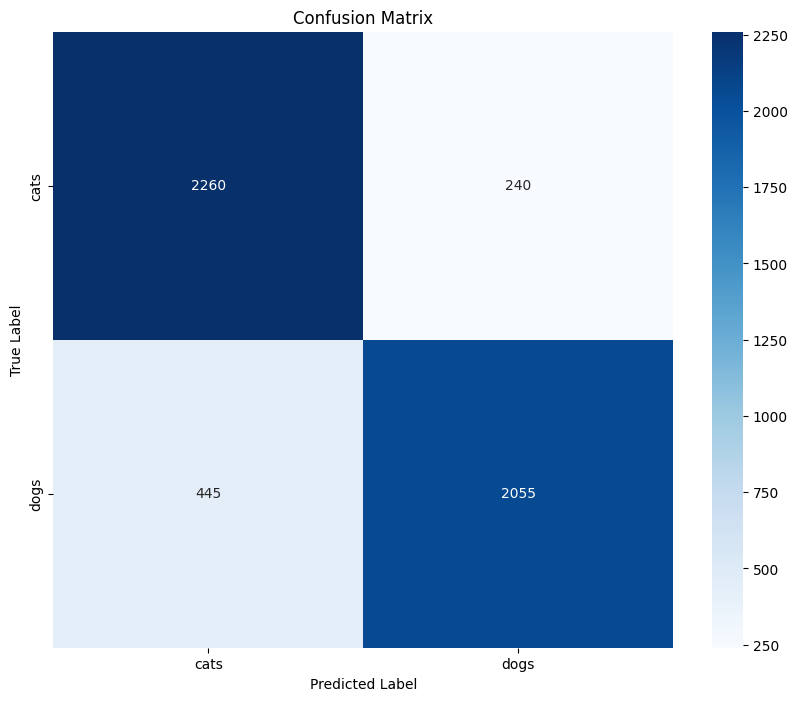

In [40]:
cm = confusion_matrix.compute().cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["cats", "dogs"], yticklabels=["cats", "dogs"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()